Using TensorFlow backend.
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py

(48000, 28, 28, 1)
(10000, 28, 28, 1)


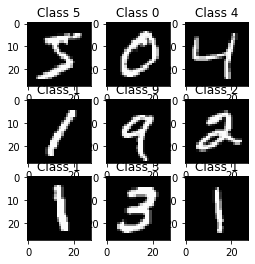

In [1]:

# coding: utf-8

get_ipython().magic('matplotlib inline')


import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

np.random.seed(25)


# 下載 mnist 資料
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train: trainning data
# y_train: labels of each trainning data
# x_test: testing data
# y_test: labels of each testing data

plt.figure(figsize=(4,4))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title("Class %s" %y_train[i])


# add channel  開始為 CNN 準備  矩陣要變成 (資料筆數, 長, 寬, 黑白=1/彩色=3)
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

## 手動將 mnist 的訓練資料依 80%/20% 的比例分做訓練及驗證資料
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=25) 
#手動切出驗證集，test_size = 0.2，驗證集2成，隨機種子隨機抽
#No_shuffle

print(x_train.shape)
print(x_test.shape)
x_train_normalized = x_train / 255
x_val_normalized = x_val / 255
x_test_normalized = x_test / 255

def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()



In [2]:

from keras.utils import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


model = Sequential()
model.add(Conv2D(16, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))

model.add(Conv2D(36, (5,5), activation="relu", padding="same", data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

layer_utils.print_summary(model)


# 定義訓練方式
# loss function: 交叉熵
# optimizer: Adam
# 評估模型: 準確率
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## 手動將 mnist 的訓練資料依 80%/20% 的比例分做訓練及驗證資料
## from sklearn.model_selection import train_test_split
## x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=25) 
# 開始訓練
y_train_onehot = np_utils.to_categorical(y_train)

y_val_onehot = np_utils.to_categorical(y_val)


## 訓練資料開始做一些調整轉換

## rotation_range: 定義影像旋轉的角度區間，generator 會亂數來決定選轉角度
## width_shift_range: 定義影像橫向偏移位置多寡，generator 會亂數決定偏移量
## height_shift_range: 定義影像縱向偏移位置多寡，generator 會亂數決定偏移量
## shear_range: 定義錯切角度
## zoom_range: 定義放大縮小多寡

#副程式放在gen裡面(改結構)
gen = ImageDataGenerator(featurewise_center=False,
                         samplewise_center=False,
                         rotation_range=8, 
                         width_shift_range=0.08, 
                         shear_range=0.3,
                         height_shift_range=0.08, 
                         zoom_range=0.08,
                         data_format="channels_last")

## fit() 計算依賴於資料的變換所需要的統計資訊(均值方差等),只有使用featurewise_center，featurewise_std_normalization或zca_whitening時需要此函數。

gen.fit(x_train_normalized)

## 接收numpy陣列和標籤為參數,生成經過資料提升或標準化後的batch資料,並在一個無限迴圈中不斷的返回batch資料

train_generator = gen.flow(x_train_normalized, y_train_onehot, batch_size=300)  ## 根據 ImageDataGenerator 產生更多影像資料

test_gen = ImageDataGenerator(data_format="channels_last")
test_gen.fit(x_test_normalized)
test_generator = test_gen.flow(x_test_normalized, y_test, batch_size=300)


from keras.callbacks import ReduceLROnPlateau
## 訓練時依條件降低學習率。
## 說明：監控val_loss，在該數值等待10次，若無較好表現則調降學習率，但最低若為0.0001，則不在調降。
## keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, 
## min_lr=0.0001)

## monitor：被監測的量
## factor：每次減少學習率的因子，學習率將以lr=lr*factor的形式減少
## patience：當patience個epoch過去而模型性能不提升時，學習率減少的動作會被觸發
## mode：’auto’, ‘min’, ‘max’之一，在min模式下，如果檢測值不再降低，則觸發學習率減少。在max模式下，當檢測值不再上升則觸##發學習率減少。
## epsilon：閾值，用來確定是否進入檢測值的“平原區“
## cooldown：學習率減少後，會經過cooldown個epoch才重新進行正常操作
## min_lr：學習率的下限

#learning_rate應該隨著iteration遞減
learning_rate_function = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, #準確率重複3次就要減少
                                            verbose=1, 
                                            factor=0.5, #準確率乘上factor設成下一個learning_rate
                                            min_lr=0.00001) #降到最小值


# 開始訓練
train_history = model.fit_generator(train_generator, 
                                    steps_per_epoch=300, 
                                    epochs=5, 
                                    verbose=1,
                                    validation_data=(x_val, y_val_onehot), #validation自己挑，不是電腦選
                                    callbacks=[learning_rate_function])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_1 (Dense)      

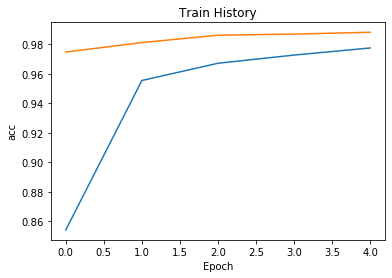

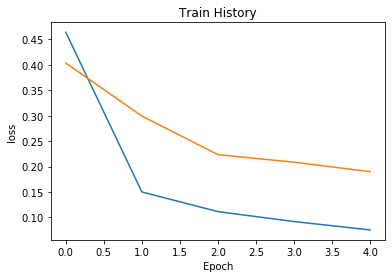

10000/10000 [==============================] - 3s 269us/step

Accuracy 0.9923%

[7 2 1 ... 4 5 6]


d:\programfiles\python37\lib\site-packages\ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


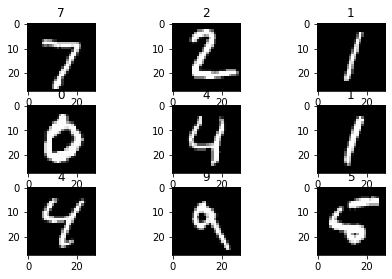

In [3]:
#train_history = model.fit(x_train_normalized, y_train_onehot, validation_split=0.2, epochs=10, batch_size=300, verbose=1)#電腦選


show_train_history(train_history, 'acc', 'val_acc')

show_train_history(train_history, 'loss', 'val_loss')

y_test_onehot = np_utils.to_categorical(y_test)
score = model.evaluate(x_test, y_test_onehot)
print()
print("Accuracy {}%".format(score[1]))

results = model.predict_classes(x_test)
print()
print(results)


import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, results)

plot_confusion_matrix(cm, range(0, 9))

incorrect = np.where(y_test != results)[0]
test_set = np.squeeze(x_test, axis=3)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    idx = incorrect[i]
    img = test_set[idx]
    plt.imshow(img, cmap="gray")
    plt.title("{}/{}".format(y_test[idx], results[idx]))



correct = np.where(y_test == results)[0]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    idx = correct[i]
    img = test_set[idx]
    plt.imshow(img, cmap="gray")
    plt.title("{}".format(y_test[idx]))


model.save_weights("cnn2.h5")
